In [3]:
import pandas as pd
import numpy as np
import glob
import unidecode
import re

import nltk
from nltk.corpus import stopwords
import os
import spacy
from happytransformer import HappyTextToText
from happytransformer import TTSettings
from langdetect import detect
from sklearn.feature_extraction.text import TfidfVectorizer

In [256]:
def fusion_csv(liste_csv):
    dataset = pd.read_csv(liste_csv[0])
    for ds in liste_csv[1:]:
        dataset = pd.concat([dataset, pd.read_csv(ds)], ignore_index=True)
    
    return dataset

In [4]:
dataset = pd.read_csv("data/icloud_mails_Baptiste.CSV")
dataset.head()

,Objet,Corps,De: (nom),De: (adresse),De: (type),A: (nom),A: (adresse),A: (type)
0,IF28 : complement analyse de sentiments,IF28 <https://moodle.utt.fr/course/view.php?id...,MATTA Nada (via Moodle),noreply@utt.fr,SMTP,GUICHARD BAPTISTE,baptiste.guichard@utt.fr,SMTP
1,[sport] Pôle universitaire UTT,"Bonjour à tous,\r\n\r\n\r\nVous souhaitez inté...",sport-request@utt.fr,sport-request@utt.fr,SMTP,sport,sport@utt.fr,SMTP
2,Re: Notes Bac de Français,Coucou !\r\n\r\nJe comprends ta déception car ...,dub co,cookiegroovie@gmail.com,SMTP,Baptiste Guichard,baptisteguichard@icloud.com,SMTP
3,anglais,\r\n\r\n\r\n\r\n\r\n\r\nEnvoyé à partir d’Outl...,Karin Beurton,kbeurton@hotmail.fr,SMTP,baptisteguichard@icloud.com,baptisteguichard@icloud.com,SMTP
4,Re : Changement de classe,"Baptiste,\r\n\r\nAprès étude de votre mail, no...",Faurie Delphine,Delphine.Faurie@ac-versailles.fr,SMTP,Baptiste Guichard,baptisteguichard@icloud.com,SMTP


In [5]:
dataset.shape

(5711, 8)

In [257]:
liste_csv = glob.glob('data'+os.path.sep+'*.CSV')

dataset = fusion_csv(liste_csv)

# dataset = pd.read_csv("data/gmail_mails_Oscar.CSV")
# dataset = dataset.iloc[:100]
dataset.shape

(7450, 19)

In [238]:
happy_tt = HappyTextToText("MARIAN", "Helsinki-NLP/opus-mt-fr-en")
args = TTSettings(min_length=2)

C:\Users\oscar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\transformers\models\marian\tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
11/23/2022 14:46:14 - INFO - happytransformer.happy_transformer -   Using model: cpu


In [239]:
def text_translation(text):
    # print('ppppppppppppp', text.split()[:10])
    try:
        lang = detect(text)
    except:
        lang = "error"
    if lang == "fr":
        #translate
        final_trans_text = ""
        ran = round(len(text.split())/50)
        if ran == 0:
            trans_text = happy_tt.generate_text(text, args=args)
            final_trans_text = trans_text.text
        else:
            for i in range(ran):
                piece_of_text = ' '.join(text.split()[i*50:50+(i*50)])
                trans_text = happy_tt.generate_text(piece_of_text, args=args)
                final_trans_text = final_trans_text + " " + trans_text.text
        
    elif lang == "en":
        final_trans_text = text
        print("") #nothing happens
    else:
        #classify the email as autre
        final_trans_text = text
        print("")
    # print("ppppppppppp ", final_trans_text.split()[:10])
    return final_trans_text

In [240]:
def text_cleaning(text):
    text = str(text)
    text = unidecode.unidecode(text)
    text = re.sub(r"""[.,/"':!;\\]""", '', text)
    text = re.sub(r"""[0-9]+""", '', text) #removing numbers
    text = re.sub(r"""-""", ' ', text) #uniquement - pour les mots du style "allez-vous"
    text = re.sub('\s+', ' ', text)
    # text = text.split(' ')
    return text

In [241]:
def clean_address(text):
    index = len(text)
    text = text.replace('@', ' ')
    text = text[:index-4] + text[index-4:].replace(".", ' ')
    text = text.split(' ')
    return text

In [242]:
# def stop_words_french(text):
#     stop_words = stopwords.words('french')
#     text = [word for word in text if word not in stopwords.words('french') and len(word)>1]
#     return text

def stop_words_english(text):
    stop_words = stopwords.words('english')
    text = [word for word in text.split() if ((word not in stop_words) and (len(word)>1))]
    
    return text

In [243]:
def lemmatization(nlp, texte):
    i = 0
    # On regarde chaque mot dans le texte
    # Chaque mot a le numéro i
    for mot in texte:
        # on va lemmatizer
        doc = nlp(mot)
        for token in doc:
            texte[i] = token.lemma_.lower()
            
        i += 1
    
            
    return texte

In [244]:
def remove_https(corps):

    text_file = open(r'corps.txt', 'w',  encoding="utf-8")
    text_file.write(corps)
    text_file.close()

        
    final_text_file = open(r'final_corps.txt', 'w',  encoding="utf-8")
    reading_text_file = open(r'corps.txt', 'r',  encoding="utf-8")
    for line in reading_text_file:
        if "http" not in line:
            final_text_file.write(line)
            
    final_text_file.close()
    reading_text_file.close()

    with open('final_corps.txt', 'r', encoding="utf-8") as file:
        return file.read()

In [245]:
def columns_treatment(df):
    df = df.iloc[:,[0,1,3]]
    df = df.rename(columns={'Objet':'objet','Corps':'corps', 'De: (adresse)':'adresse'})
    return df

In [246]:
def data_cleaning(df):
    
    df = columns_treatment(df)
    
    # nlp_fr = spacy.load('fr_core_news_md')
    nlp_en = spacy.load('en_core_web_md')
    
    is_english = False

    for i in df.index:
        
        corps = remove_https(str(df['corps'][i]))

        corps = text_cleaning(corps)

        # #corps = text_translation(corps)
        
        objet = text_cleaning(df['objet'][i])

        # # objet = text_translation(objet)

        
        #stop words cleaning for object
        objet = stop_words_english(objet)
        # objet = stop_words_french(objet)
        print("pppppppppp", objet)
        # Lemmatization
        # objet_fr = lemmatization(nlp_fr, objet)
        objet_en = lemmatization(nlp_en, objet)
        
        # on vérifie si l'objet a été lemmatizé en anglais ou non
        # if objet_en != objet:
        #     is_english = True
        # if is_english:
        # objet = objet_en
        corps = stop_words_english(corps)
        corps = lemmatization(nlp_en, corps)
        # else:
        #     objet = objet_fr
        #     corps = stop_words_french(corps)
        #     corps = lemmatization(nlp_fr, corps)

        df['objet'][i] = objet_en
        df['corps'][i] = corps

        df['adresse'][i] = clean_address(df['adresse'][i])

    return df

In [247]:
dataset = data_cleaning(dataset)

pppppppppp ['Votre', 'course', 'de', 'lundi', 'matin', 'en', 'Uber']
pppppppppp ['Verifier', 'mes', 'frais', 'dannulation']
pppppppppp ['Votre', 'course', 'de', 'lundi', 'matin', 'en', 'Uber']
pppppppppp ['Ventes', 'flash', 'sur', 'les', 'bieres', 'blondes']
pppppppppp ['Alerte', 'email', 'Appartement', 'pieces', 'Paris']
pppppppppp ['Alerte', 'email', 'Studio', 'Paris']
pppppppppp ['erinette', 'repondu', 'votre', 'avis', 'sur', 'Google']
pppppppppp ['Nous', 'ne', 'parvenons', 'pas', 'traiter', 'votre', 'paiement']
pppppppppp ['BRED', 'Reception', 'dun', 'virement', 'instantane', 'EUR']
pppppppppp ['Le', 'solde', 'de', 'votre', 'compte', 'est', 'bas']
pppppppppp ['Alerte', 'email', 'Studio', 'Paris']
pppppppppp ['Alerte', 'email', 'Studio', 'Paris']
pppppppppp ['Receive', 'scholarship', 'joining', 'emlyon']
pppppppppp ['Notification', 'importante', 'concernant', 'les', 'parametres', 'de', 'votre', 'compte', 'Instagram']
pppppppppp ['La', 'boutique', 'Montaigne']
pppppppppp ['Demain', '

In [248]:
dataset

,objet,corps,adresse
0,"[votre, course, de, lundi, matin, en, uber]","[octobre, bientot, oscar, voici, la, facture, ...","[noreply, uber, com]"
1,"[verifier, mes, frais, dannulation]","[veuillez, repondre, au, dessus, de, cette, li...","[contact_b92ffc2b-70bb-4116-ab15-6363af4dc0ce,..."
2,"[votre, course, de, lundi, matin, en, uber]","[octobre, oscar, merci, davoir, utilise, uber,...","[noreply, uber, com]"
3,"[vente, flash, sur, les, biere, blonde]","[decouvrez, vite, la, selection, jusqua, demai...","[saveur-biere, m.perfectdraft, com]"
4,"[alerte, email, appartement, piece, paris]","[une, annonce, correspond, votre, recherche, l...","[users-alertes, pap, fr]"
...,...,...,...
95,"[un, message, important, est, disponible, dans...","[nous, avon, bien, enregistre, votre, demande,...","[assurance-maladie, info.ameli, fr]"
96,"[confirmation, de, commande, how, we, dau]","[merci, pour, votre, commande, how, we, dau, a...","[support, weezevent, com]"
97,"[request, how, would, rate, support, receive, ?]","[hello, utilisateur, lime, d, love, hear, thin...","[support, limebike, com]"
98,"[recu, spotify]","[votre, recu, premium, student, mars, id, de, ...","[no-reply, spotify, com]"


# Tfidf : Feature extraction

In [249]:
# corpusCorps = np.array([])
# for text in dataset['corps']:
#     corpusCorps = np.append(corpusCorps, ' '.join(text))

# corpusObjet = np.array([])
# for text in dataset['objet']:
#     corpusObjet = np.append(corpusObjet, ' '.join(text))

# corpusAdresse = np.array([])
# for text in dataset['adresse']:
#     corpusAdresse = np.append(corpusAdresse, ' '.join(text))

# # corpus

In [250]:
# # vectorizer = TfidfVectorizer()
# # X1 = vectorizer.fit_transform(corpusCorps)
# # X2 = vectorizer.fit_transform(corpusObjet)
# # X3 = vectorizer.fit_transform(corpusAdresse)
# # # print("Ensemble des mots : ", vectorizer.get_feature_names() )
# # # print("\nMatrice TfIDF : \n", X.toarray())

# # final_dataset = dataset

# # temp = np.array([])
# # for text in X1.toarray():
# #     to_temp = [str(item) for item in text.tolist()]
# #     temp = np.append(temp, ' '.join(to_temp))


# # final_dataset['corps'] = temp

# # i = 0
# for corp in final_dataset['corps']:
#     corp_temp = corp.split()
#     corp_temp = [float(x) for x in corp_temp]
#     final_dataset['corps'][i] = corp_temp
#     i = i + 1


# temp = np.array([])
# for text in X2.toarray():
#     to_temp = [str(item) for item in text.tolist()]
#     temp = np.append(temp, ' '.join(to_temp))


# final_dataset['objet'] = temp

# i = 0
# for corp in final_dataset['objet']:
#     corp_temp = corp.split()
#     corp_temp = [float(x) for x in corp_temp]
#     final_dataset['objet'][i] = corp_temp
#     i = i + 1


# temp = np.array([])
# for text in X2.toarray():
#     to_temp = [str(item) for item in text.tolist()]
#     temp = np.append(temp, ' '.join(to_temp))


# final_dataset['adresse'] = temp

# i = 0
# for corp in final_dataset['adresse']:
#     corp_temp = corp.split()
#     corp_temp = [float(x) for x in corp_temp]
#     final_dataset['adresse'][i] = corp_temp
#     i = i + 1

    
# final_dataset.head()
# # dataset['corps'] = X.toarray()

# # dataset['corps']

In [251]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [252]:
final_dataset = dataset
dataset.head()

,objet,corps,adresse
0,"[votre, course, de, lundi, matin, en, uber]","[octobre, bientot, oscar, voici, la, facture, ...","[noreply, uber, com]"
1,"[verifier, mes, frais, dannulation]","[veuillez, repondre, au, dessus, de, cette, li...","[contact_b92ffc2b-70bb-4116-ab15-6363af4dc0ce,..."
2,"[votre, course, de, lundi, matin, en, uber]","[octobre, oscar, merci, davoir, utilise, uber,...","[noreply, uber, com]"
3,"[vente, flash, sur, les, biere, blonde]","[decouvrez, vite, la, selection, jusqua, demai...","[saveur-biere, m.perfectdraft, com]"
4,"[alerte, email, appartement, piece, paris]","[une, annonce, correspond, votre, recherche, l...","[users-alertes, pap, fr]"


In [253]:
# initialize the vectorizer
vectorizer = TfidfVectorizer()

corpusCorps = np.array([])
for text in dataset['corps']:
    corpusCorps = np.append(corpusCorps, ' '.join(text))
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(corpusCorps)

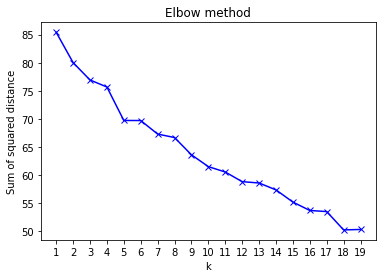

In [254]:
# # initialize kmeans with 3 centroids
# kmeans = KMeans(n_clusters=3, random_state=42)
# # fit the model
# kmeans.fit(X)
# # store cluster labels in a variable
# clusters = kmeans.labels_

def find_optimal_clusters(data, max_k):
    Sum_of_squared_distance = []
    K = range(1,max_k)
    for k in K:
        km = KMeans(n_clusters = k)
        km = km.fit(data)
        Sum_of_squared_distance.append(km.inertia_)
    plt.plot(K, Sum_of_squared_distance, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum of squared distance')
    plt.title('Elbow method')
    plt.xticks(K)
    plt.show()
    
find_optimal_clusters(X, 20)

In [255]:
# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=12, random_state=42)
# fit the model
kmeans.fit(X)
# store cluster labels in a variable
clusters = kmeans.labels_